In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
import cv2, os, gc, glob
from tqdm import tqdm
import random

from tensorflow.keras import layers, models

import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

2021-12-25 10:40:35.842376: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-25 10:40:35.842434: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
os.listdir('/home/k/Documents/a')

['COVID',
 'Lung_Opacity.metadata.xlsx',
 'Normal.metadata.xlsx',
 'Viral Pneumonia',
 'Lung_Opacity',
 'Normal',
 'COVID.metadata.xlsx',
 'README.md.txt',
 'Viral Pneumonia.metadata.xlsx']

In [3]:
os.listdir('/home/k/Documents/a')

['COVID',
 'Lung_Opacity.metadata.xlsx',
 'Normal.metadata.xlsx',
 'Viral Pneumonia',
 'Lung_Opacity',
 'Normal',
 'COVID.metadata.xlsx',
 'README.md.txt',
 'Viral Pneumonia.metadata.xlsx']

In [4]:
# Image paths

imagePaths = []
for dirname, _, filenames in os.walk('/home/k/Documents/a'):
    for filename in filenames:
        if (filename[-3:] == 'png'):
            imagePaths.append(os.path.join(dirname, filename))

In [5]:
# Shuffle the path
random.shuffle(imagePaths)

In [6]:
# Data - Label

Data = []
Target = []
resize = 150

cat = {'Viral Pneumonia': 'Pneumonia', 'Normal': 'Normal', 'COVID': 'Covid-19',
       'Lung_Opacity': 'Lung Opacity'}

i = 0
for imagePath in tqdm(imagePaths):
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (resize, resize)) /255

    Data.append(image)
    Target.append(cat[label])
    i += 1
    
    # Taking only 3000 images
    if(i == 3000):
        break
print(len(Data))

 14%|█████▍                                | 2999/21165 [00:27<02:44, 110.17it/s]

3000


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


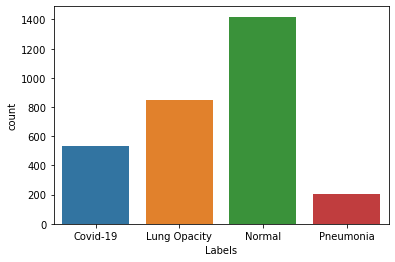

Normal: 1419
Lung Opacity: 847
Pneumonia:  203
Covid-19: 531


In [7]:
# Count by Label

df = pd.DataFrame(Target,columns=['Labels'])
sns.countplot(df['Labels'])
plt.show()

print('Normal:',Target.count('Normal'))
print('Lung Opacity:',Target.count('Lung Opacity'))
print('Pneumonia: ',Target.count('Pneumonia'))
print('Covid-19:',Target.count('Covid-19'))

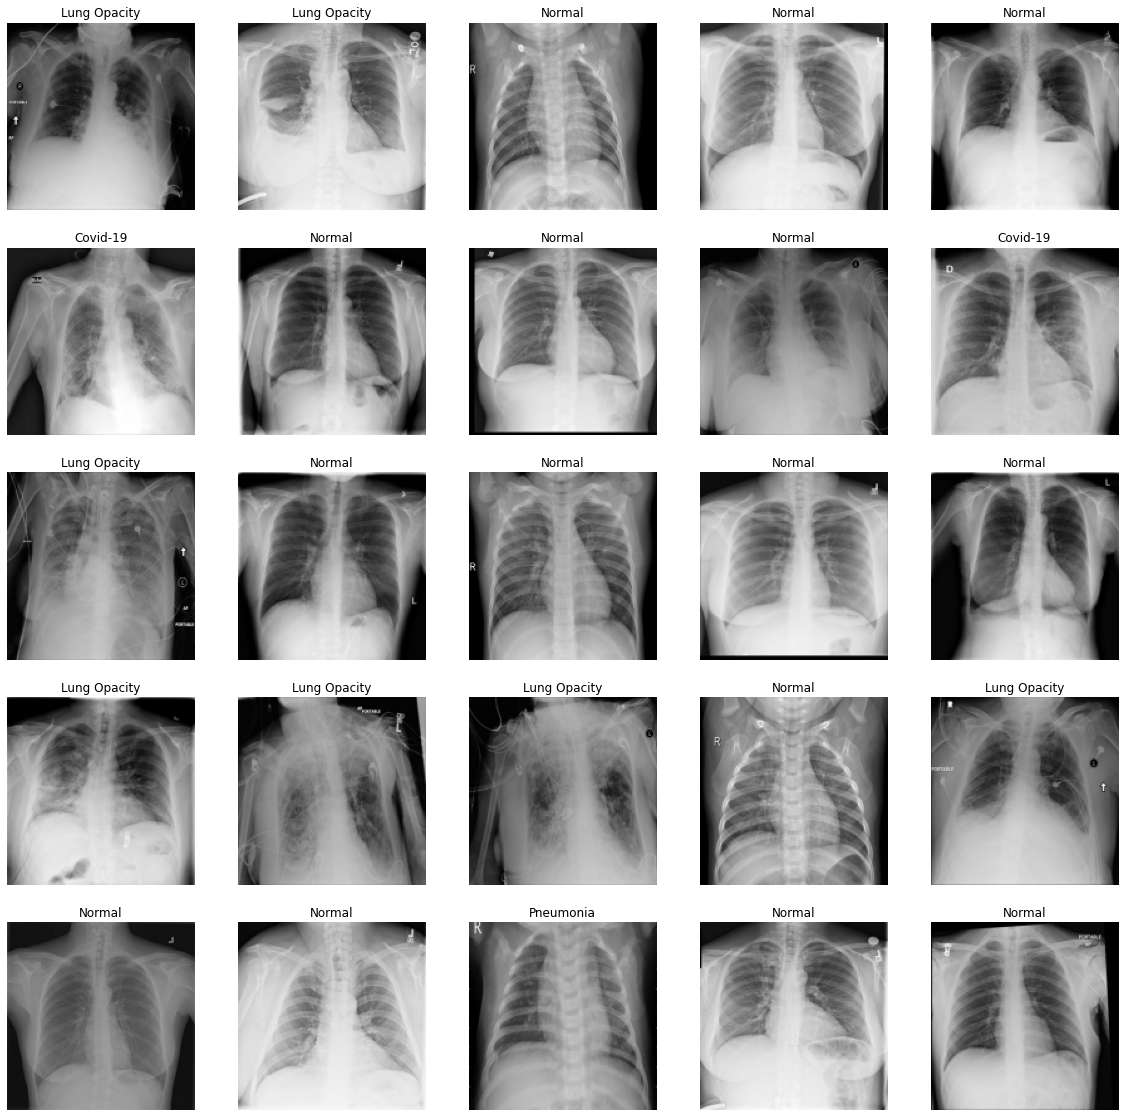

In [10]:
# Show Images

plt.figure(figsize=(20,20))
# for n , i in enumerate(list(np.random.randint(0,len(imagePaths),25))) : 
for n , i in enumerate(list(np.random.randint(0,3000,25))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(Data[i] , cmap='gray')
    plt.title(Target[i])
    plt.axis('off')     
plt.show()

# Prepare Data

In [14]:
# encode labels as integers

le = LabelEncoder()
labels = le.fit_transform(Target)
labels = to_categorical(labels)

print(le.classes_)
print(labels[0])

['Covid-19' 'Lung Opacity' 'Normal' 'Pneumonia']
[0. 1. 0. 0.]


In [15]:
# split Data

(x_train, x_test, y_train, y_test) = train_test_split(Data, labels,test_size=0.20,
                                                      stratify=labels,random_state=42)

trainX = np.array(x_train)
testX = np.array(x_test)
trainY = np.array(y_train)
testY = np.array(y_test)

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(2400, 150, 150, 3)
(600, 150, 150, 3)
(2400, 4)
(600, 4)


In [16]:
trainX[0]

array([[[0.05882353, 0.05882353, 0.05882353],
        [0.06666667, 0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667],
        ...,
        [0.14901961, 0.14901961, 0.14901961],
        [0.23921569, 0.23921569, 0.23921569],
        [0.36862745, 0.36862745, 0.36862745]],

       [[0.05490196, 0.05490196, 0.05490196],
        [0.06666667, 0.06666667, 0.06666667],
        [0.0627451 , 0.0627451 , 0.0627451 ],
        ...,
        [0.10588235, 0.10588235, 0.10588235],
        [0.17647059, 0.17647059, 0.17647059],
        [0.29019608, 0.29019608, 0.29019608]],

       [[0.05490196, 0.05490196, 0.05490196],
        [0.0627451 , 0.0627451 , 0.0627451 ],
        [0.0627451 , 0.0627451 , 0.0627451 ],
        ...,
        [0.10196078, 0.10196078, 0.10196078],
        [0.17254902, 0.17254902, 0.17254902],
        [0.28627451, 0.28627451, 0.28627451]],

       ...,

       [[0.81176471, 0.81176471, 0.81176471],
        [0.88627451, 0.88627451, 0.88627451],
        [0.88627451, 0

# Model

In [17]:
s = 150 # size

In [18]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size =(3,3), activation = "relu", input_shape=(s,s,3), kernel_initializer='he_normal',))
# model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 64, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128, kernel_size =(3,3), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2), strides = (1,1)))

model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(64, activation = "relu"))
model.add(Dropout(0.2))
# model.add(Dense(3, activation = "softmax"))
# we have 4 classes
model.add(Dense(4, activation = "softmax"))

2021-12-24 08:09:58.972788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:
2021-12-24 08:09:58.972929: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-24 08:09:58.973034: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kali): /proc/driver/nvidia/version does not exist
2021-12-24 08:09:58.973749: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-24 08:09:59.166889: W tensorflow/cor

In [21]:
# Compile 

model.compile(optimizer = Adam(),
              loss= keras.losses.categorical_crossentropy,
              metrics= ['accuracy'])

In [22]:
# Model Details

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 33, 33, 128)      0

In [23]:
epochs = 8

ThisModel = model.fit(trainX, trainY, epochs=epochs, batch_size=40, verbose=1)

2021-12-24 08:10:53.485814: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 648000000 exceeds 10% of free system memory.


Epoch 1/8


2021-12-24 08:10:54.737163: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35684352 exceeds 10% of free system memory.


60/60 [==============================] - 183s 3s/step - loss: 1.6891 - accuracy: 0.5683
Epoch 2/8
60/60 [==============================] - 193s 3s/step - loss: 0.6741 - accuracy: 0.7271
Epoch 3/8
60/60 [==============================] - 193s 3s/step - loss: 0.5954 - accuracy: 0.7750
Epoch 4/8
60/60 [==============================] - 191s 3s/step - loss: 0.5376 - accuracy: 0.7862
Epoch 5/8
60/60 [==============================] - 192s 3s/step - loss: 0.4379 - accuracy: 0.8308
Epoch 6/8
60/60 [==============================] - 191s 3s/step - loss: 0.3859 - accuracy: 0.8533
Epoch 7/8
60/60 [==============================] - 192s 3s/step - loss: 0.3300 - accuracy: 0.8721
Epoch 8/8
60/60 [==============================] - 192s 3s/step - loss: 0.3010 - accuracy: 0.8871


# Results

In [24]:
modelLoss, modelAccuracy = model.evaluate(testX, testY, verbose=0)

print('Test Loss is {}'.format(modelLoss))
print('Test Accuracy is {}'.format(modelAccuracy ))

Test Loss is 0.526826024055481
Test Accuracy is 0.8183333277702332


In [25]:
class_names = ['COVID-19','Normal','Viral Pneumonia']

y_pred = model.predict(testX)
print(class_names[np.argmax(y_pred[1])])

Normal


In [26]:
# classification report on train
batch_size=40

predIdxs = model.predict (trainX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(trainY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.98641   0.84419   0.90977       430
Lung Opacity    0.94462   0.87408   0.90798       683
      Normal    0.89541   0.98148   0.93647      1134
   Pneumonia    0.96815   0.99346   0.98065       153

    accuracy                        0.92708      2400
   macro avg    0.94865   0.92330   0.93372      2400
weighted avg    0.93036   0.92708   0.92640      2400



In [27]:
# classification report on test

predIdxs = model.predict(testX, batch_size=batch_size)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

    Covid-19    0.95161   0.55140   0.69822       107
Lung Opacity    0.83974   0.76608   0.80122       171
      Normal    0.77876   0.92958   0.84751       284
   Pneumonia    0.86047   0.97368   0.91358        38

    accuracy                        0.81833       600
   macro avg    0.85765   0.80519   0.81514       600
weighted avg    0.83214   0.81833   0.81188       600



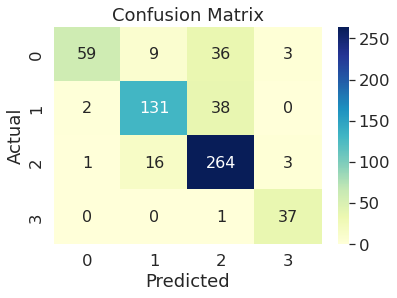

In [34]:
# Plotting Confusion Matrix
x = confusion_matrix(testY.argmax(axis=1),y_pred.argmax(axis=1))
Confusion_Matrix = pd.DataFrame(x)

sns.set(font_scale=1.5, color_codes=True, palette='deep')
sns.heatmap(Confusion_Matrix, annot=True, annot_kws={'size':16}, fmt='d', cmap='YlGnBu')

plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title('Confusion Matrix')
plt.show()

In [35]:
model.save('CNN_Covid19_Xray_V1.h5') 

In [ ]:
pip install imagecodecs